## Churn Dataset: IBM Watson Analytics. Sample Telecom Data

> https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.stats.weightstats import ttest_ind
from __future__ import division

# modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale, MinMaxScaler, normalize, StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# gridsearch
from sklearn.model_selection import GridSearchCV
import os
from time import sleep
from pprint import pprint
from sklearn.cross_validation import  ShuffleSplit
from sklearn.grid_search import ParameterGrid
# from ipyparallel import Client
from sklearn.externals import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Explore the Data

In [2]:
data_path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
data = pd.read_csv(data_path)
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [3]:
data.shape

(7043, 21)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
for col in data.columns:
    print col, data[col].unique()

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ..., '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27  5
 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68 32 55
 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0 39]
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

_Customers with 0 months tenure, have yet to accumulate TotalCharges. In this context they shouldn't be part of training a model to predict churn so they will be omitted from the dataset._

In [6]:
# Removing Data with no accumulated charges
data = data.loc[data.TotalCharges != ' ', :]

In [7]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
# formating columns

data.TotalCharges = data.TotalCharges.astype(float)
data.tenure = data.tenure.astype(float)

exempt_cols = ['customerID', 'gender', 'Contract', 'PaymentMethod']

for col in data.columns:
    if (data[col].dtype == object) & (col not in exempt_cols):
        if col == "InternetService":
            data[col] = data[col].map(lambda x: 0 if x == "No" else 1)
        else:
            data[col] = data[col].map(lambda x: 1 if x == "Yes" else 0)
            
# Comparing year contract to month-to-month
data.Contract = data.Contract.map(lambda x: 1 if 'year' in x else 0)

# Create a column for automatic payments
data['AutoPayments'] = map(lambda x: 1 if 'automatic' in x else 0, data.PaymentMethod)

# Expanding out gender column
data = pd.get_dummies(data, columns=['gender'])

In [9]:
data.head(3)

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AutoPayments,gender_Female,gender_Male
0,7590-VHVEG,0,1,0,1.0,0,0,1,0,1,...,0,0,1,Electronic check,29.85,29.85,0,0,1,0
1,5575-GNVDE,0,0,0,34.0,1,0,1,1,0,...,0,1,0,Mailed check,56.95,1889.50,0,0,0,1
2,3668-QPYBK,0,0,0,2.0,1,0,1,1,1,...,0,0,1,Mailed check,53.85,108.15,1,0,0,1


In [10]:
data.dtypes

customerID           object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure              float64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
AutoPayments          int64
gender_Female         uint8
gender_Male           uint8
dtype: object

Data is Clean

In [11]:
# split data into design & target matrix
X = data.drop(['customerID', 'PaymentMethod', 'Churn'], axis=1)
y = data.Churn

print 'Design Matrix Shape: {}'.format(X.shape)
print 'Target Matrix Shape: {}'.format(y.shape)

Design Matrix Shape: (7032, 20)
Target Matrix Shape: (7032,)


In [12]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
Partner,7032.0,0.482509,0.499729,0.00,0.0000,0.000,1.0000,1.00
Dependents,7032.0,0.298493,0.457629,0.00,0.0000,0.000,1.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
PhoneService,7032.0,0.903299,0.295571,0.00,1.0000,1.000,1.0000,1.00
MultipleLines,7032.0,0.421928,0.493902,0.00,0.0000,0.000,1.0000,1.00
InternetService,7032.0,0.783845,0.411650,0.00,1.0000,1.000,1.0000,1.00
OnlineSecurity,7032.0,0.286547,0.452180,0.00,0.0000,0.000,1.0000,1.00
OnlineBackup,7032.0,0.344852,0.475354,0.00,0.0000,0.000,1.0000,1.00
DeviceProtection,7032.0,0.343857,0.475028,0.00,0.0000,0.000,1.0000,1.00


In [13]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X[numerical_cols].head()

,tenure,MonthlyCharges,TotalCharges
0,1.0,29.85,29.85
1,34.0,56.95,1889.50
2,2.0,53.85,108.15
3,45.0,42.30,1840.75
4,2.0,70.70,151.65


In [14]:
ss= StandardScaler()

for col in X.columns:
    if col in numerical_cols:
        X[col] = ss.fit_transform(np.array(X[col]).reshape(X.shape[0], 1))        

In [15]:
X[numerical_cols].head()

,tenure,MonthlyCharges,TotalCharges
0,-1.280248,-1.161694,-0.994194
1,0.064303,-0.260878,-0.173740
2,-1.239504,-0.363923,-0.959649
3,0.512486,-0.747850,-0.195248
4,-1.239504,0.196178,-0.940457


In [16]:
X.isnull().sum()

SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
TotalCharges        0
AutoPayments        0
gender_Female       0
gender_Male         0
dtype: int64

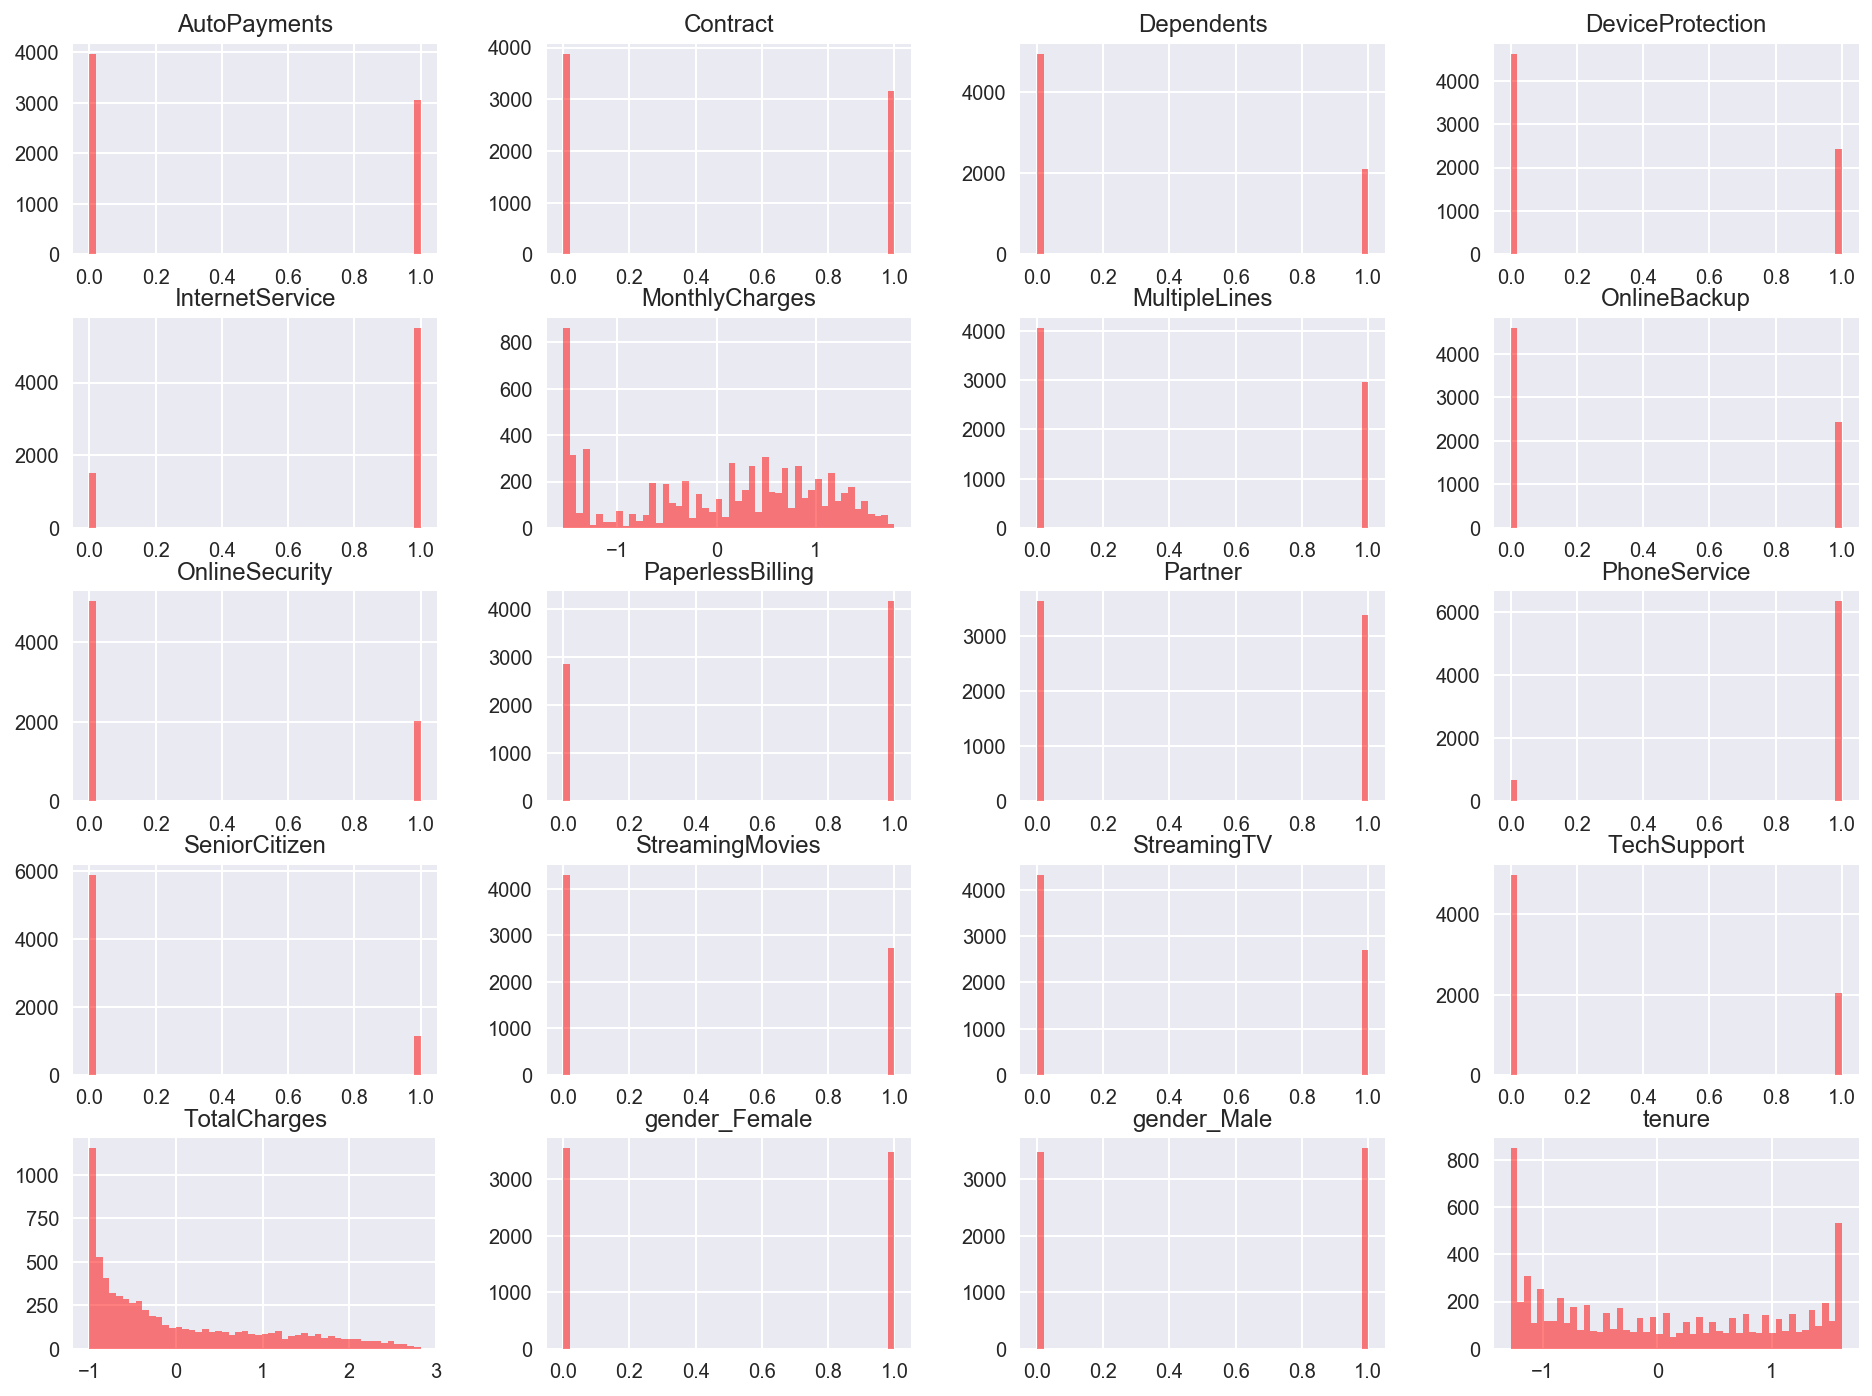

In [17]:
# Distribution of features - after rescaling
X.hist(color='r', alpha=0.5, bins=50, figsize=(16,12))
plt.show()

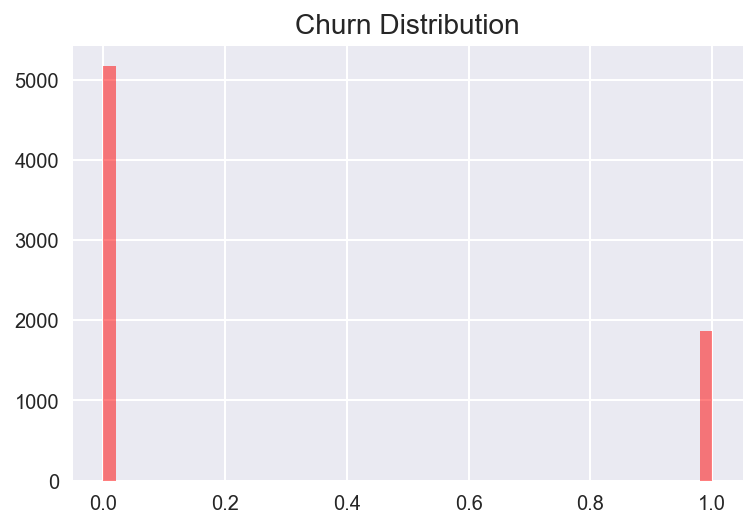

In [18]:
y.hist(color='r', alpha=0.5, bins=50, figsize=(6,4))
plt.title('Churn Distribution', fontsize=14)
plt.show()

-------------

In [19]:
X_train, X_holdout, Y_train, Y_holdout = train_test_split(X, y, test_size = 0.20, random_state=8)

print 'X_train Shape: {}'.format(X_train.shape)
print 'Y_train Shape: {}'.format(Y_train.shape)
print '\nX_holdout Shape: {}'.format(X_holdout.shape)
print 'Y_holdout Shape: {}'.format(Y_holdout.shape)

X_train Shape: (5625, 20)
Y_train Shape: (5625,)

X_holdout Shape: (1407, 20)
Y_holdout Shape: (1407,)


Models

In [20]:
model_dict = {
    
    "Logistic Regression": {"Estimator": LogisticRegression(),
                            "Param_Grid": {
                                        'solver':['liblinear'],
                                        'C':np.logspace(-4, -1, 50),
                                        'penalty':['l1','l2'] },
                            "Best_Param": None,
                            "Best_Score": None,
                            "Best_Estimator": None,                           
                           },
    
       "Random Forest": {"Estimator": RandomForestClassifier() , 
                         "Param_Grid": {
                                        'max_features': ['auto', 'log2', 1.0],
                                        'n_estimators': [10, 50],
                                        'min_samples_split': [2, 3, 10] },
                         "Best_Param": None,         
                         "Best_Score": None,
                         "Best_Estimator": None,                    
                        },

                "KNN": {"Estimator": KNeighborsClassifier() ,
                        "Param_Grid": {
                                       'n_neighbors':np.arange(1,51),
                                       'weights':['distance','uniform'] },
                        "Best_Param": None,
                        "Best_Score": None,
                        "Best_Estimator": None,
                       }
}

In [21]:
# helper functions

def grid_search_params(X, y, estimator, param_grid, cv):
    '''GridSearch model params and return best one'''
    model_gs = GridSearchCV(estimator, param_grid=param_grid, cv=5, verbose=1)
    model_gs.fit(X, y)
    
    best_params = model_gs.best_params_
    best_score = model_gs.best_score_
    best_estim = model_gs.best_estimator_
    
    return best_params, best_score, best_estim


def baseline_accuracy(target_var):
    '''Defining two classification baseline accuracies'''
    # theoretical accuracy (Random Guessing)
    theo_base = (sum(target_var == 0) / len(target_var))**2 + (sum(target_var == 1) / len(target_var))**2

    # Guessing Majority Class
    base = np.max([sum(target_var == 0), sum(target_var == 1)]) / len(target_var)
    
    print 'Theoretical Accuracy {:.2f}'.format(theo_base)
    print 'Baseline Accuracy {:.2f}'.format(base)
    
    return theo_base, base


def model_acc(model_name, model_dict):
    '''GridSearch Accuracy'''
    print "%s:" %model_name
    print "Best Parameters", model_dict[model_name]["Best_Param"]
    print "GridSearch Accuracy %.2f" %model_dict[model_name]["Best_Score"]
    print
    

def plot_cm(y_tru, y_pred, model):
    '''Plot the Confusion Matrix'''
    cm = confusion_matrix(Y_holdout, y_hat)
    cmap=plt.cm.Blues
    title = '%s Confusion Matrix' %model
    classes = ['Retain', 'Churn']

    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.grid(False)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

In [22]:
for model in model_dict:
    print model
    bp, bs, be = grid_search_params(X_train, Y_train, model_dict[model]["Estimator"], 
                                                     model_dict[model]["Param_Grid"], 5)
    model_dict[model]["Best_Param"] = bp
    model_dict[model]["Best_Score"] = bs
    model_dict[model]["Best_Estimator"] = be

KNN
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.5min finished


Random Forest
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   28.7s finished


Logistic Regression
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    7.8s finished


In [23]:
model_dict

{'KNN': {'Best_Estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=26, p=2,
             weights='uniform'),
  'Best_Param': {'n_neighbors': 26, 'weights': 'uniform'},
  'Best_Score': 0.79448888888888891,
  'Estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'),
  'Param_Grid': {'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
          35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
   'weights': ['distance', 'uniform']}},
 'Logistic Regression': {'Best_Estimator': LogisticRegression(C=0.042919342601287783, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs

In [24]:
_, baseline = baseline_accuracy(Y_train)

Theoretical Accuracy 0.61
Baseline Accuracy 0.73


In [25]:
for model in model_dict:
    model_acc(model, model_dict)

KNN:
Best Parameters {'n_neighbors': 26, 'weights': 'uniform'}
GridSearch Accuracy 0.79

Random Forest:
Best Parameters {'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 50}
GridSearch Accuracy 0.80

Logistic Regression:
Best Parameters {'penalty': 'l2', 'C': 0.042919342601287783, 'solver': 'liblinear'}
GridSearch Accuracy 0.80



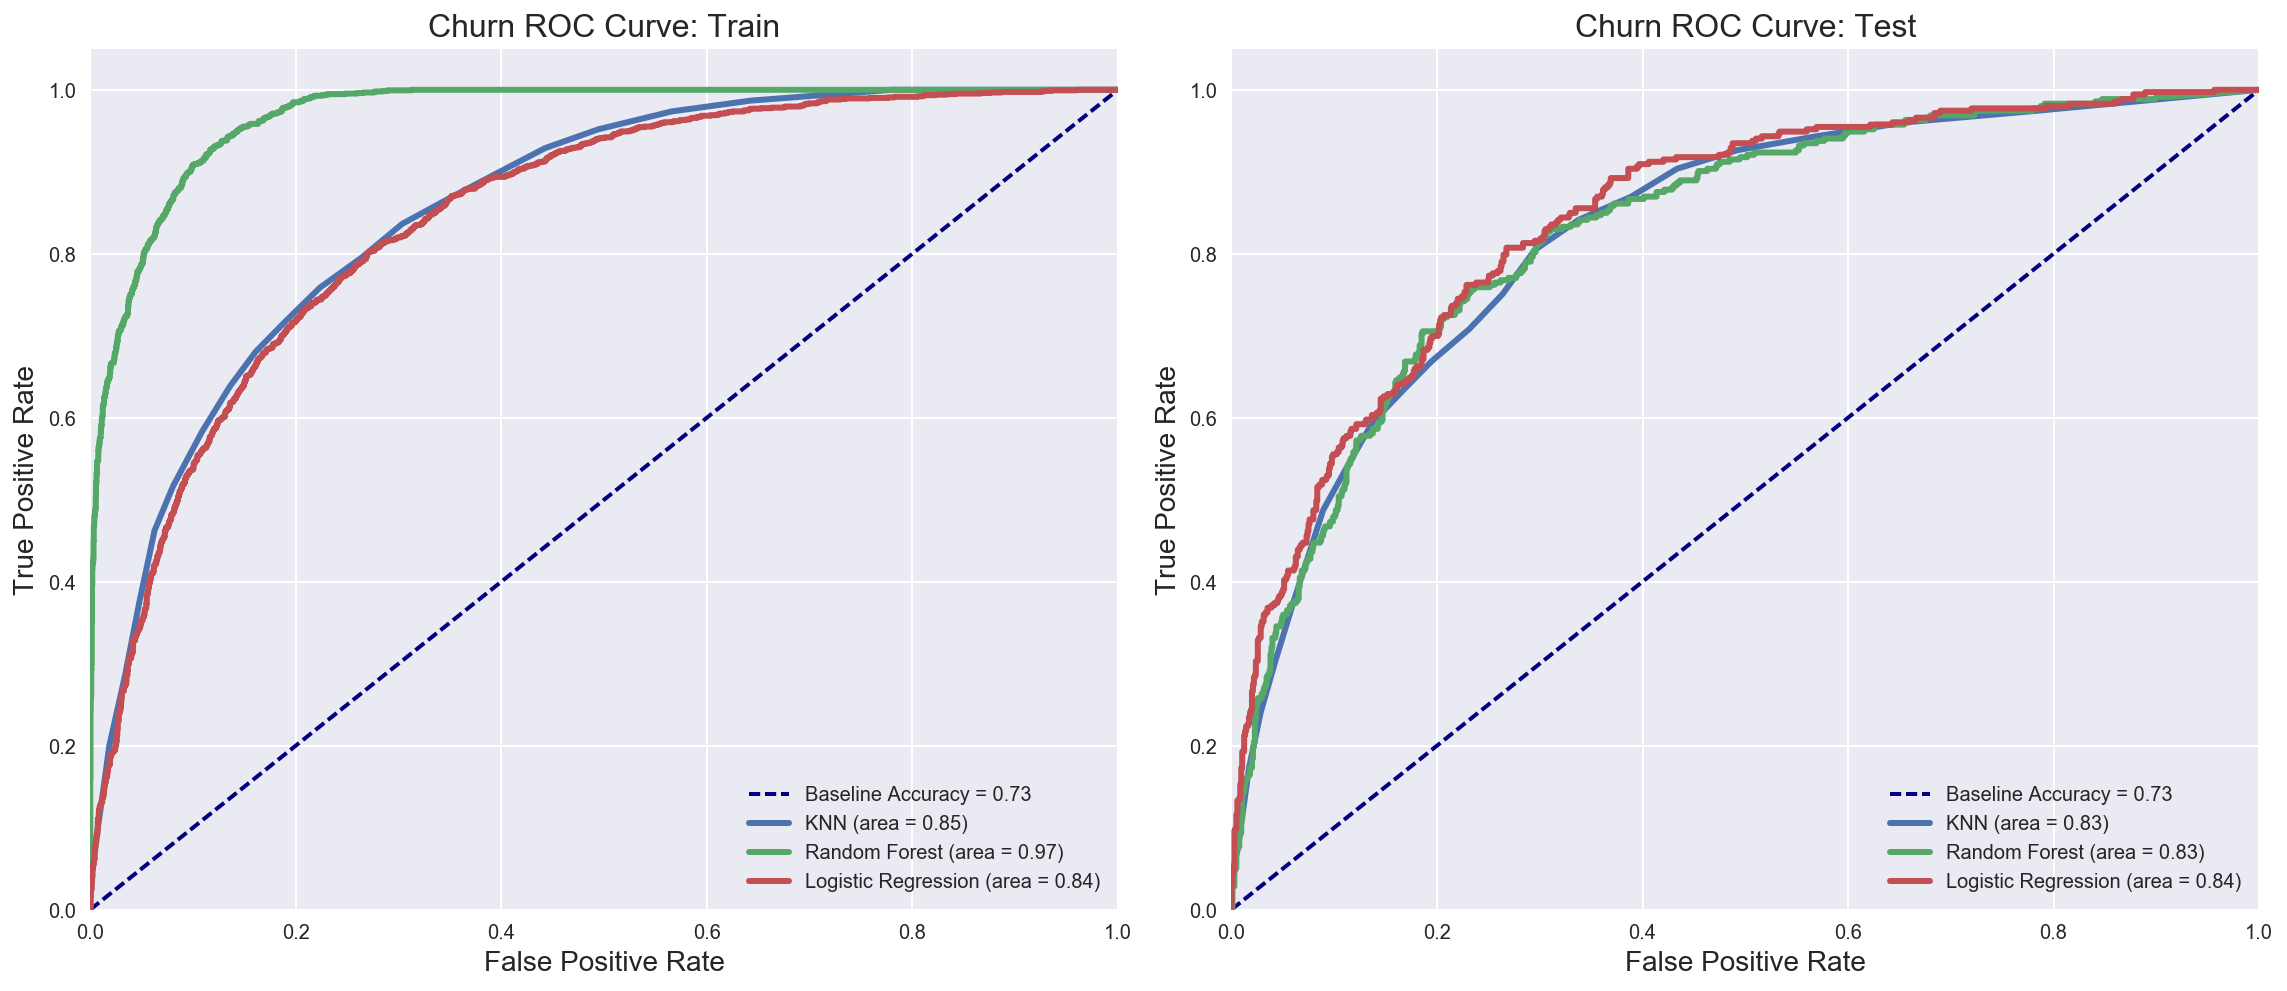

In [26]:
f, ax = plt.subplots(1, 2, figsize=(16, 7))
lw = 2

train = True

for i in range(2):
    ax[i].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', 
             label='Baseline Accuracy = %0.2f' %baseline)

    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])

    ax[i].set_xlabel('False Positive Rate', fontsize=14)
    ax[i].set_ylabel('True Positive Rate', fontsize=14)
    
    if train:
        X = X_train
        Y = Y_train
        title = 'Train'
    else:
        X = X_holdout
        Y = Y_holdout
        title = 'Test'

    for model in model_dict:
        fpr_, tpr_, _ = roc_curve(Y, model_dict[model]["Best_Estimator"].predict_proba(X)[:, 1])
        roc_auc = auc(fpr_, tpr_)

        ax[i].plot(fpr_, tpr_,
             lw=lw+1, label='%s (area = %0.2f)' %(model,roc_auc))

        ax[i].legend(loc="lower right")
        ax[i].set_title('Churn ROC Curve: %s' %title, fontsize=16)
        
    train = False
    
plt.tight_layout()
plt.show()

Testing on the holdout set

KNN 

Predicted     0    1   All
Actual                    
0           935  119  1054
1           162  191   353
All        1097  310  1407 



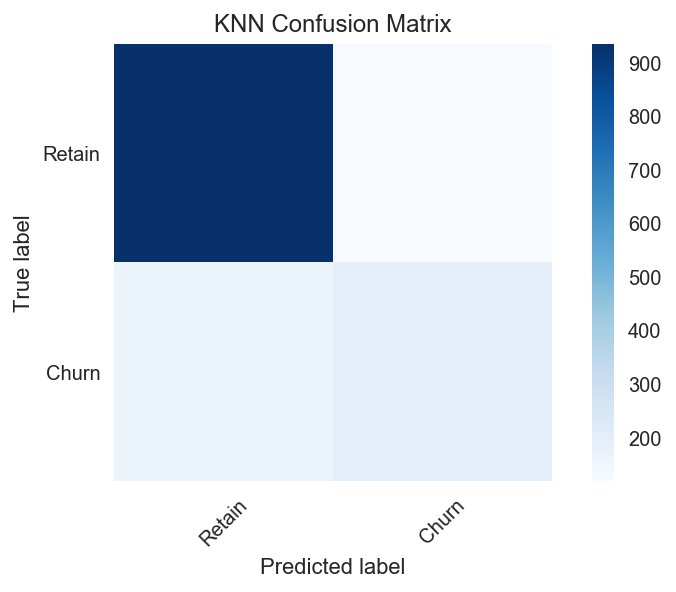

             precision    recall  f1-score   support

     Retain       0.85      0.89      0.87      1054
      Churn       0.62      0.54      0.58       353

avg / total       0.79      0.80      0.80      1407


Random Forest 

Predicted     0    1   All
Actual                    
0           953  101  1054
1           187  166   353
All        1140  267  1407 



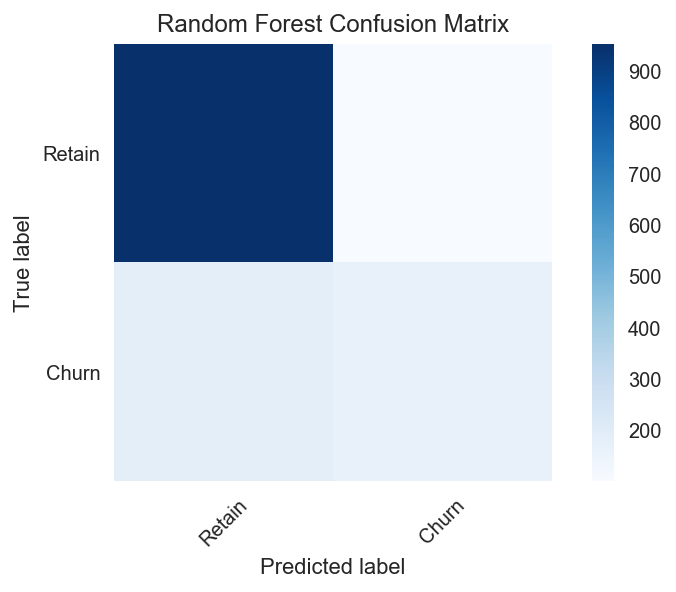

             precision    recall  f1-score   support

     Retain       0.84      0.90      0.87      1054
      Churn       0.62      0.47      0.54       353

avg / total       0.78      0.80      0.79      1407


Logistic Regression 

Predicted     0    1   All
Actual                    
0           953  101  1054
1           161  192   353
All        1114  293  1407 



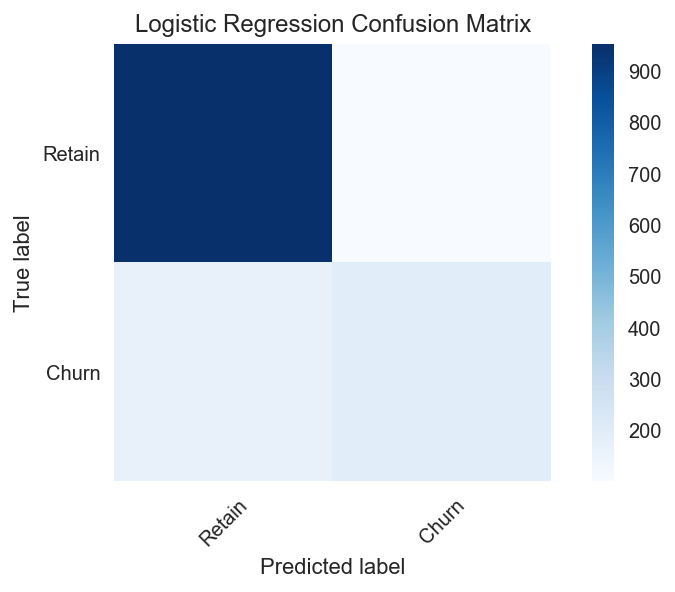

             precision    recall  f1-score   support

     Retain       0.86      0.90      0.88      1054
      Churn       0.66      0.54      0.59       353

avg / total       0.81      0.81      0.81      1407




In [27]:
for model in model_dict:
    y_hat = model_dict[model]["Best_Estimator"].predict(X_holdout)

    churn_cm = pd.crosstab(Y_holdout, y_hat, rownames=['Actual'], colnames=['Predicted'], margins=True)

    print model, "\n"
    print churn_cm, "\n"
    plot_cm(Y_holdout, y_hat, model)
    print classification_report(Y_holdout, y_hat, target_names=['Retain', 'Churn']), "\n"

Precision Recall

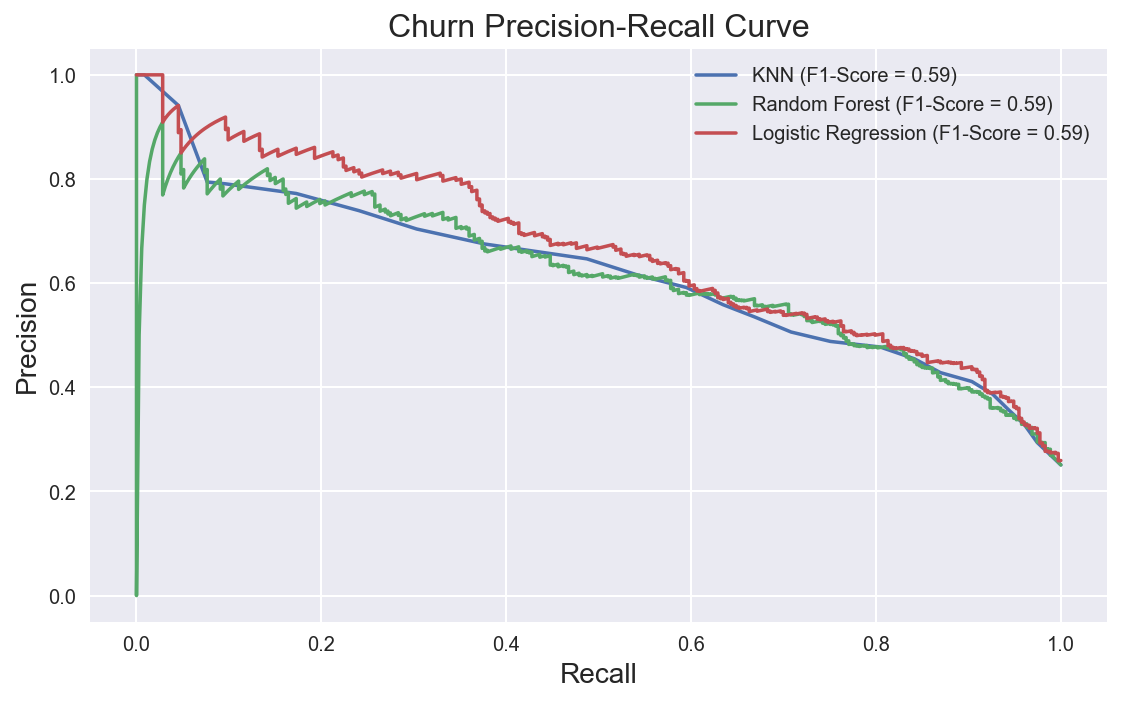

In [28]:
plt.figure(figsize=(8,5))
plt.title('Churn Precision-Recall Curve', fontsize=16)
plt.ylabel('Precision', fontsize=14)
plt.xlabel('Recall', fontsize=14)
plt.tight_layout()

for model in model_dict:
    precision, recall, thresholds = \
    precision_recall_curve(Y_holdout, model_dict[model]["Best_Estimator"].predict_proba(X_holdout)[:, 1])
    churn_f1 = f1_score(Y_holdout, y_hat)
    
    plt.plot(recall, precision, label='%s (F1-Score = %0.2f)' %(model, churn_f1))

plt.legend(loc='best')
plt.show()

Learning Curve

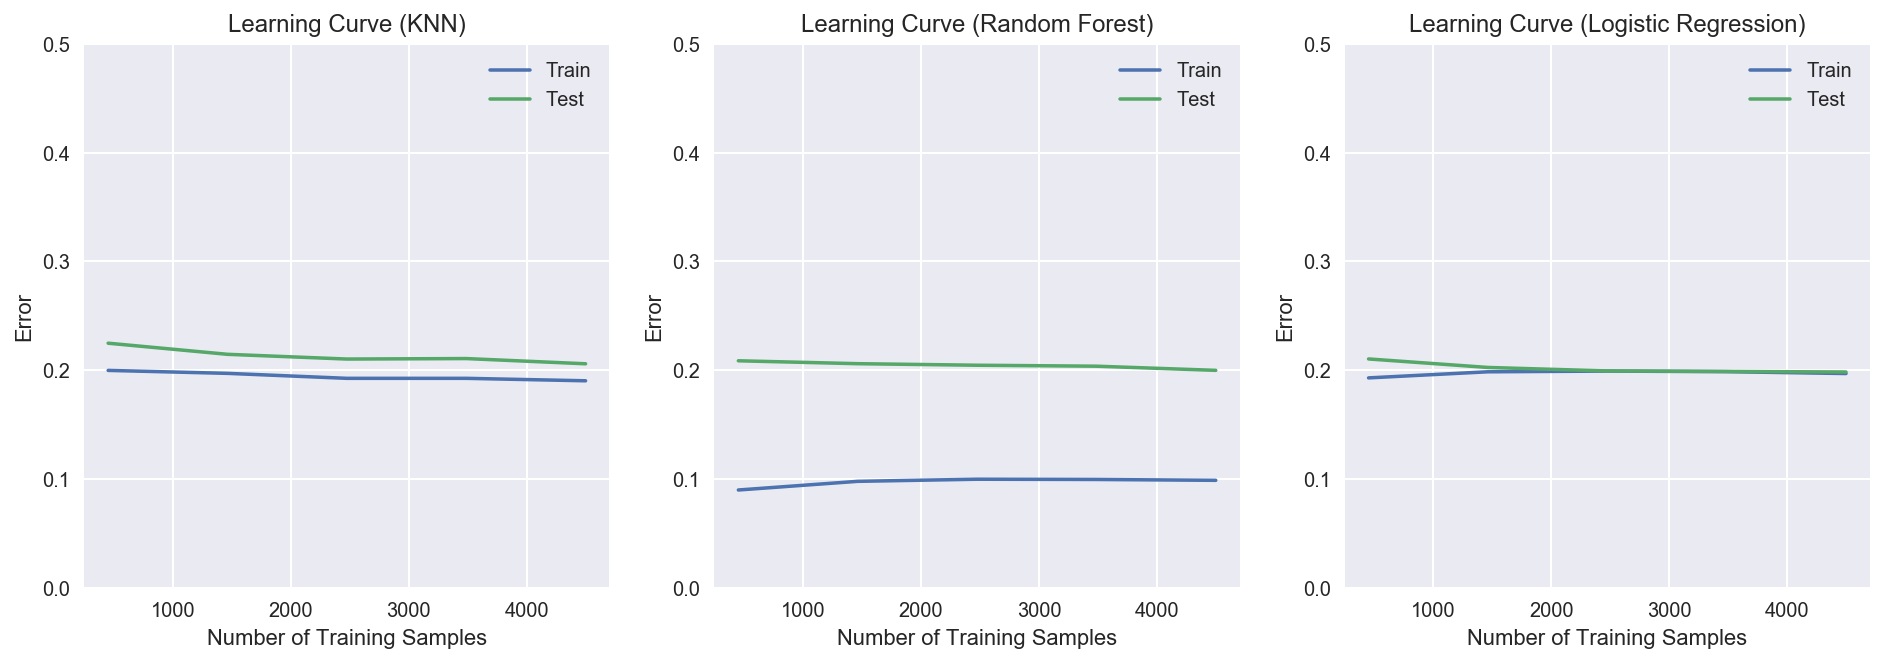

In [29]:
cv = ShuffleSplit(n=X_train.shape[0], n_iter=10, test_size=0.2, random_state=8)

f, ax = plt.subplots(1, 3, figsize=(16, 5))
i = 0
for model in model_dict.keys():
    train_sizes, train_scores, test_scores = learning_curve(model_dict[model]["Best_Estimator"], X_train, Y_train, 
                                                            train_sizes=np.array([0.1, 0.325, 0.55, 0.775, 1.]) ,cv=cv)

    ax[i].plot(train_sizes, 1- train_scores.mean(axis=1), label='Train')
    ax[i].plot(train_sizes, 1- test_scores.mean(axis=1), label='Test')
    ax[i].set_ylim([0.0, .5])
    ax[i].set_xlabel('Number of Training Samples')
    ax[i].set_ylabel('Error')
    ax[i].set_title('Learning Curve (%s)' %model)
    ax[i].legend()
    i += 1
plt.show()

Feature Importance

In [30]:
model = "Random Forest"
feature_importance = model_dict[model]["Best_Estimator"].feature_importances_
feature_importance

array([ 0.02103293,  0.01506374,  0.01924548,  0.17974097,  0.00813484,
        0.01893105,  0.04255678,  0.02603971,  0.01719586,  0.01653854,
        0.02543154,  0.01805478,  0.01668613,  0.14259025,  0.02689002,
        0.18174014,  0.17607922,  0.02371996,  0.01125762,  0.01307045])

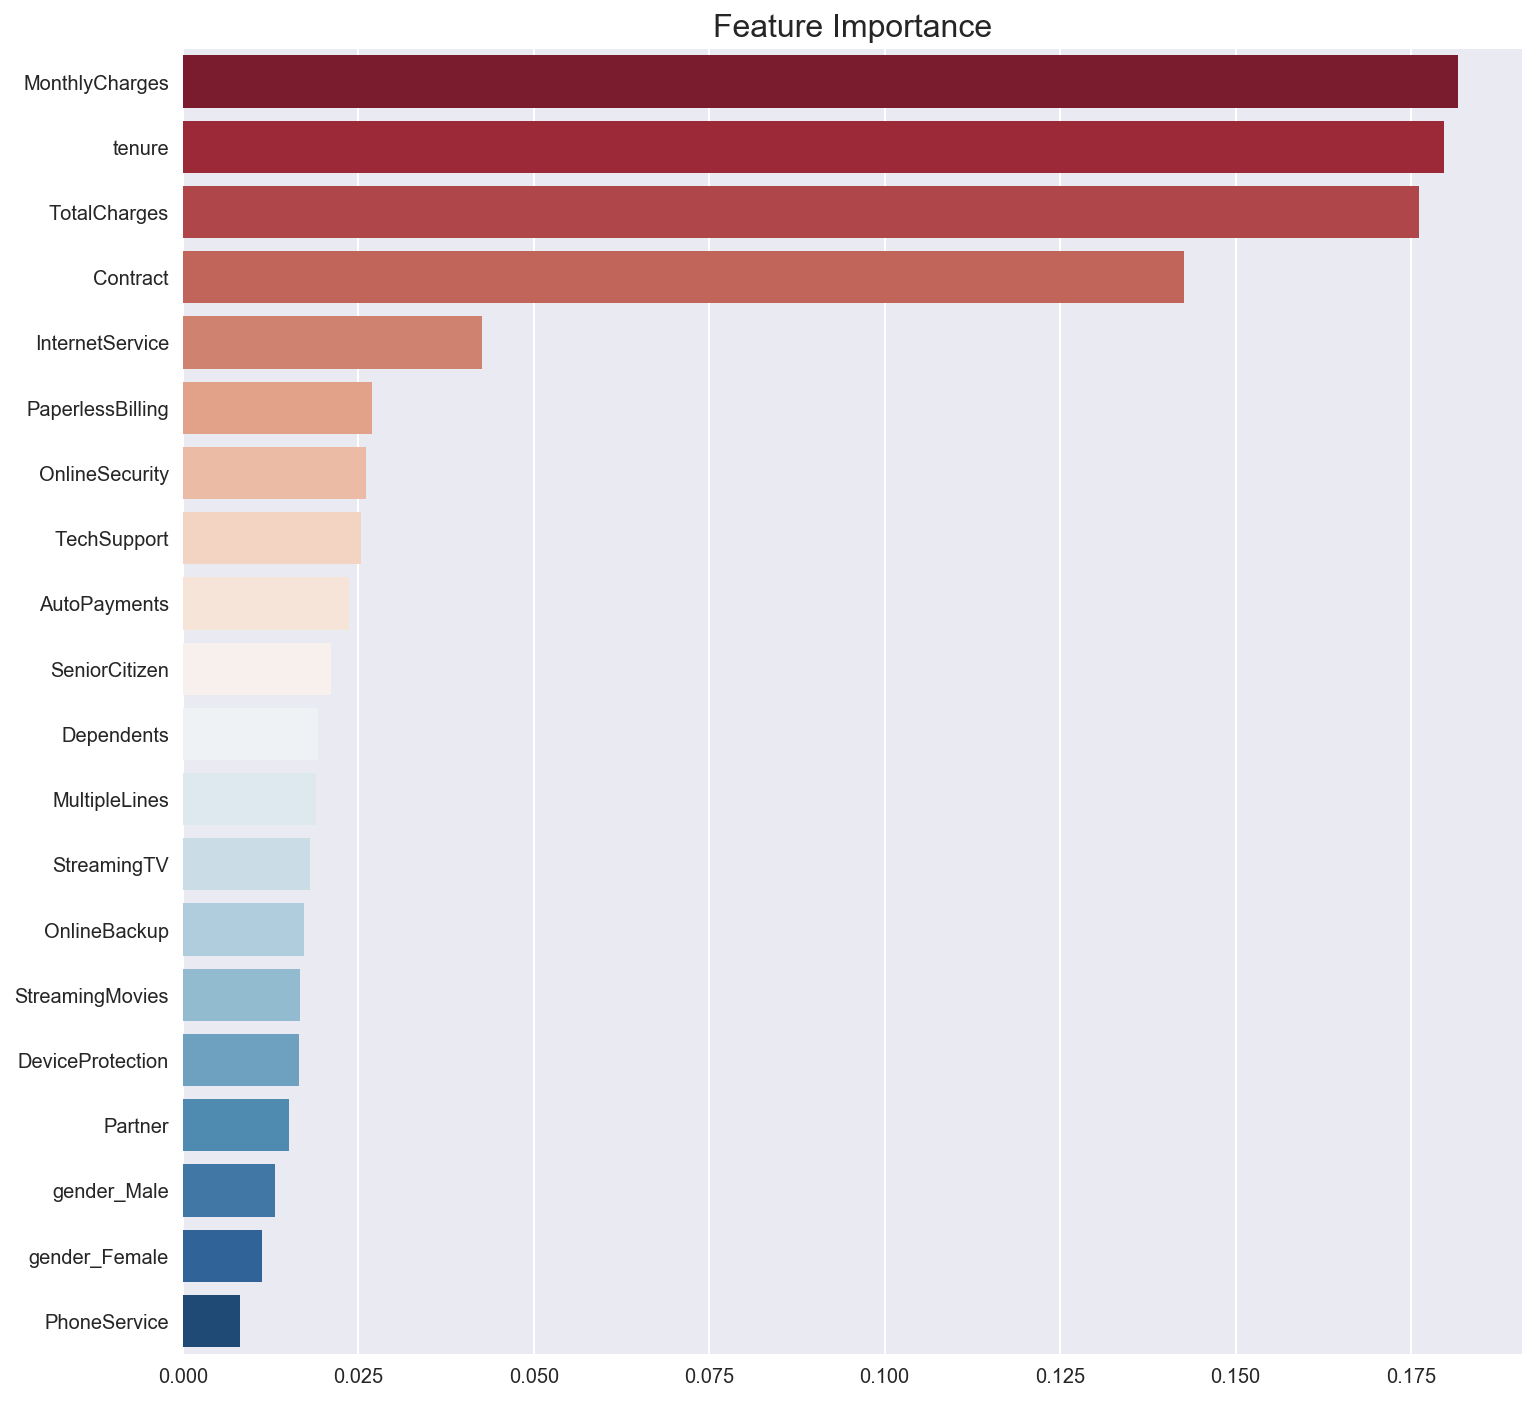

In [31]:
sorted_features = feature_importance[np.argsort(feature_importance)]

plt.figure(figsize = (12,12))
plt.title('Feature Importance', fontsize=16)
sb.barplot(sorted_features[::-1], X_train.columns[np.argsort(feature_importance)][::-1], palette="RdBu");

### Logistic Regression: Interpretation of Feature Weights

Define the odds of Y = 1 as,
$$odds = \frac{P(Y = 1)}{1 - P(Y = 1)} = e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}$$

Interpret the $\beta's$ in multiplicative terms with respect to the odds.

E.g., the interpretation of $\beta_1$ is, holding all the other variables/features fixed, for every increase of 1 in $X_1$, the odds of $Y = 1$ increases by a factor of $e^{\beta_1}$.

In [32]:
model = "Logistic Regression"
lr_coefs = model_dict[model]["Best_Estimator"].coef_[0]
lr_coefs

array([ 0.2005805 , -0.00126167, -0.22543632, -0.92253562, -0.81689408,
        0.11747406,  0.30560126, -0.52665911, -0.23305994, -0.17645105,
       -0.48766554,  0.00855948,  0.01779901, -0.77680533,  0.3015164 ,
        0.82589641,  0.12317675, -0.23881768, -0.09180356, -0.12620406])

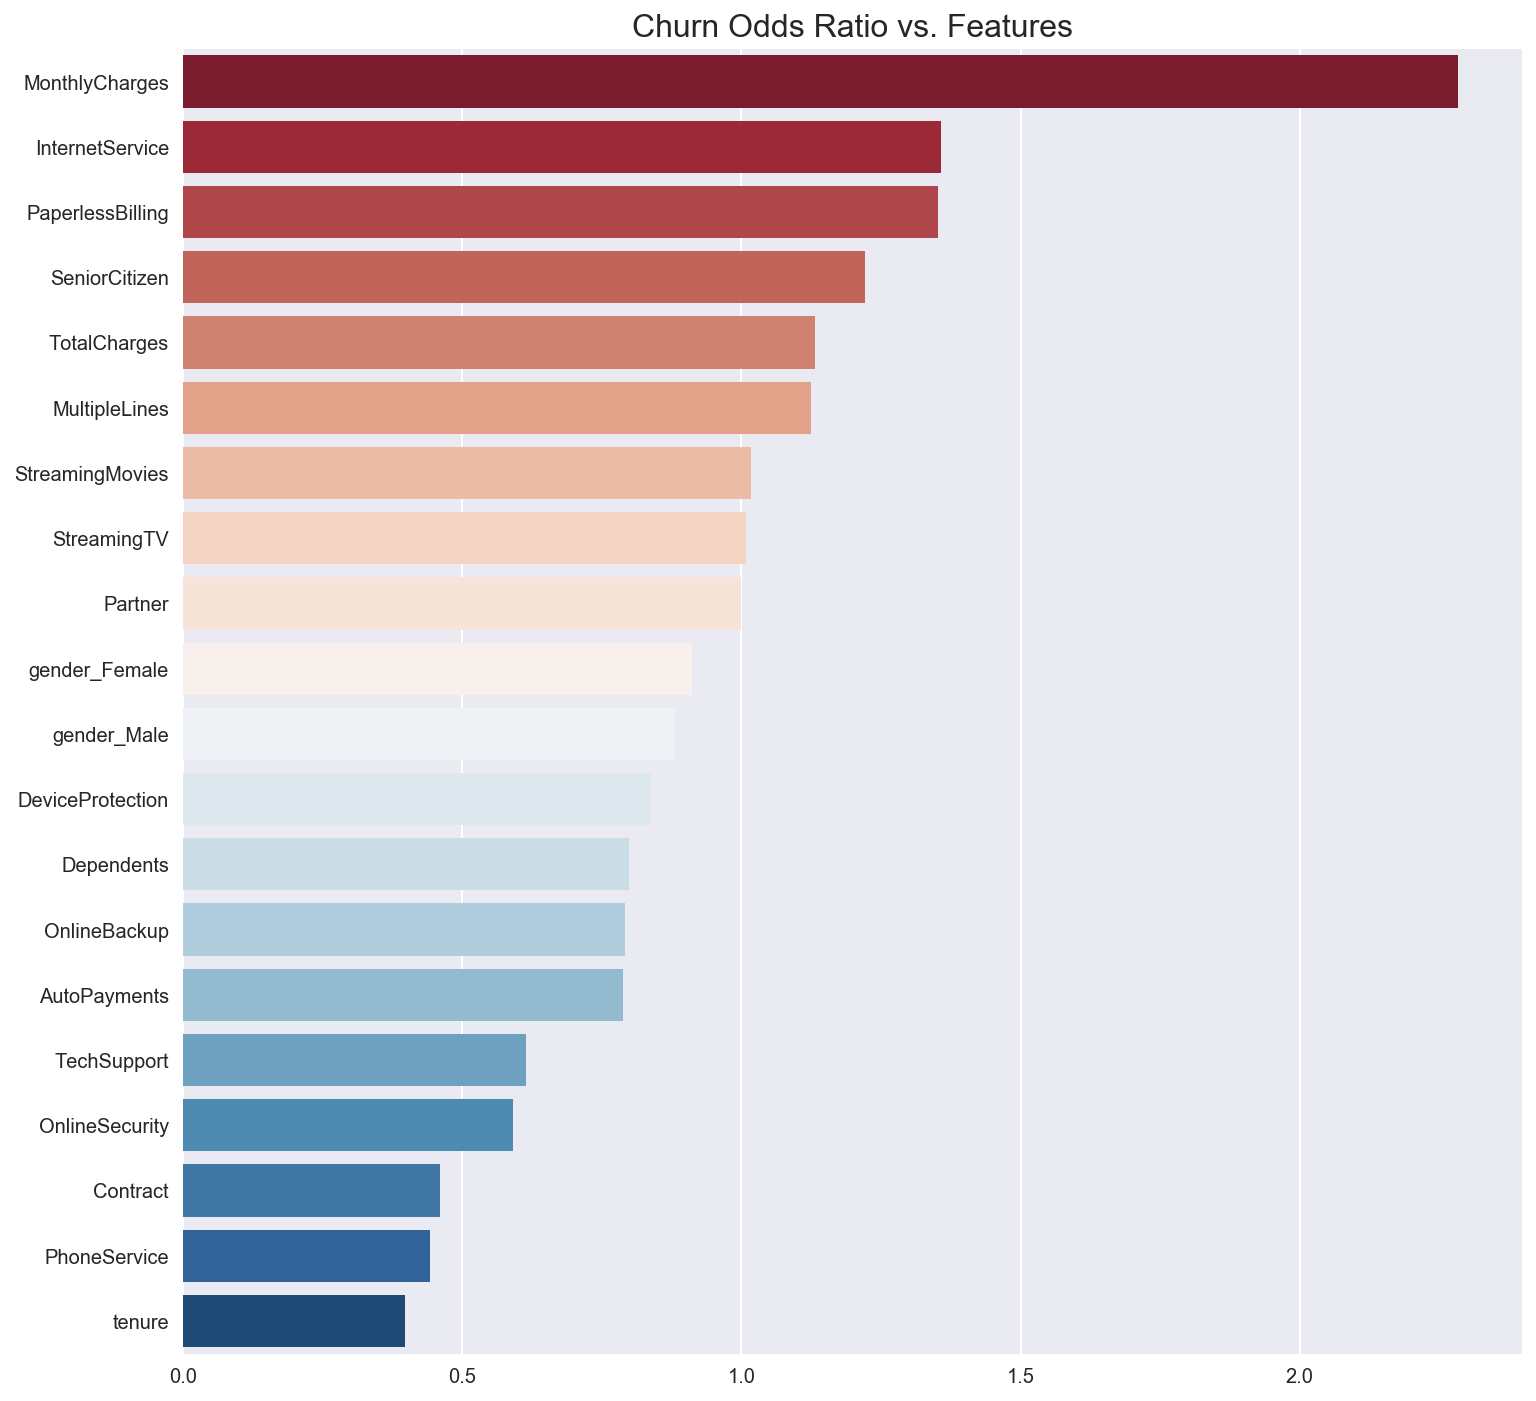

In [33]:
feature_weights = np.exp(lr_coefs)
# sorted feature by odds
sorted_features = feature_weights[np.argsort(feature_weights)]

plt.figure(figsize = (12,12))
plt.title('Churn Odds Ratio vs. Features', fontsize=16)
sb.barplot(sorted_features[::-1], X_train.columns[np.argsort(feature_weights)][::-1], palette="RdBu");